# Preliminary operations

We import the libraries and extract the zip file into the Colab environment.

In [ ]:
!pip install audiomentations

In [2]:
# Utility
from google.colab import drive
from shutil import copyfile, copy
import matplotlib.pyplot as plt
import IPython.display as ipd
import os
import pandas as pd
import numpy as np
import itertools

# Audio processing
import librosa
import librosa.display
import audiomentations

# Sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, top_k_accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Keras
import keras
from keras import regularizers
from keras.regularizers import l2
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dropout, Dense, Activation, LeakyReLU, Conv1D, MaxPooling1D
from keras.optimizers import Adam
from keras.utils import np_utils, to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!mkdir '/content/dataset'

In [ ]:
copyfile('/content/gdrive/MyDrive/Digital Signal/Dataset/Audio_Speech_Actors_01-24.zip', 'speech.zip')

In [ ]:
!unzip 'speech.zip' -d '/content/dataset'

# Data exploration

Each filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers represent:

*   Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
*   Vocal channel (01 = speech, 02 = song).
*   Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
*   Emotional intensity (01 = normal, 02 = strong (not for neutral emotion)). 
*   Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
*   Repetition (01 = 1st repetition, 02 = 2nd repetition).
*   Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [7]:
dir_list = os.listdir('/content/dataset/')
dir_list.sort()
dir_list

['Actor_01',
 'Actor_02',
 'Actor_03',
 'Actor_04',
 'Actor_05',
 'Actor_06',
 'Actor_07',
 'Actor_08',
 'Actor_09',
 'Actor_10',
 'Actor_11',
 'Actor_12',
 'Actor_13',
 'Actor_14',
 'Actor_15',
 'Actor_16',
 'Actor_17',
 'Actor_18',
 'Actor_19',
 'Actor_20',
 'Actor_21',
 'Actor_22',
 'Actor_23',
 'Actor_24']

In [ ]:
count = [0] * 24
j = 0
for i in dir_list:
  filename = os.listdir('/content/dataset/' + i)
  for f in filename:
    if f.endswith('wav'): 
      count[j]+=1
  j+=1

In [ ]:
count

[60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60]

24 subjects, each with 60 audio files.

Now let's divide the audio files according to their labels. We don't consider the neutral emotion because of two reasons: it has half the data then the other emotions and it's very similar to the calm emotion. We have found that the network cannot distinguish neutral class.

In [8]:
def switch(emotion):
  if emotion == 2:
    return 'calm'
  elif emotion == 3:
    return 'happy'
  elif emotion == 4:
    return 'sad'
  elif emotion == 5:
    return 'angry'
  elif emotion == 6:
    return 'fear'
  elif emotion == 7:
    return 'disgust'
  elif emotion == 8:
    return 'surprise'

In [9]:
emotion = []
path = []
for i in dir_list:
  filename = os.listdir('/content/dataset/' + i)
  for f in filename:
    # Remove wav extension
    id = f[:-4].split('-')
    if(id[2] != '01'):
      # Dividing according to emotions
      emotion.append(switch(int(id[2])))
      path.append('/content/dataset/' + i + '/' + f)

In [10]:
df = pd.concat([pd.DataFrame(emotion), pd.DataFrame(path)], axis = 1)
df.columns = ['emotion', 'path']
df['emotion'].value_counts()

fear        192
angry       192
sad         192
disgust     192
calm        192
happy       192
surprise    192
Name: emotion, dtype: int64

The dataset is perfectly balanced.

Let's pick some tracks.

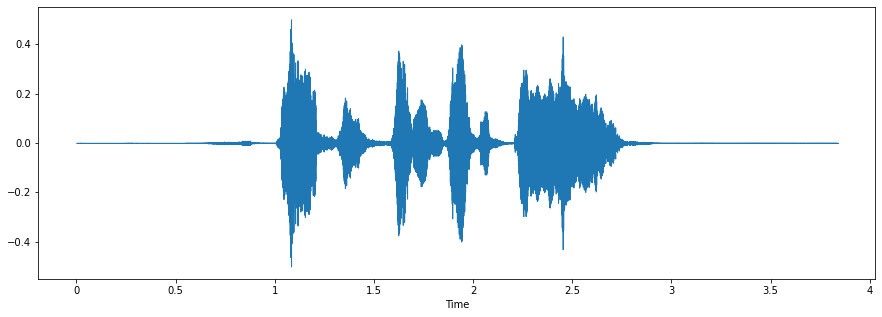

In [ ]:
# Happy - Actor 14
filename = '/content/dataset/Actor_14/03-01-03-02-02-01-14.wav'  
data, sampling_rate = librosa.load(filename)

plt.figure(figsize = (15, 5))
librosa.display.waveshow(data, sr = sampling_rate)

ipd.Audio(filename)

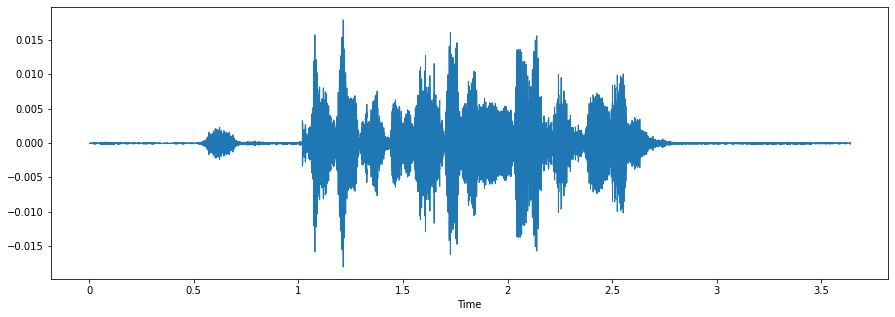

In [ ]:
# Sad - Actor 9
filename = '/content/dataset/Actor_09/03-01-04-02-02-01-09.wav'  
data, sampling_rate = librosa.load(filename)

plt.figure(figsize = (15, 5))
librosa.display.waveshow(data, sr = sampling_rate)

ipd.Audio(filename)

We notice some initial noise due to the breath before speaking.

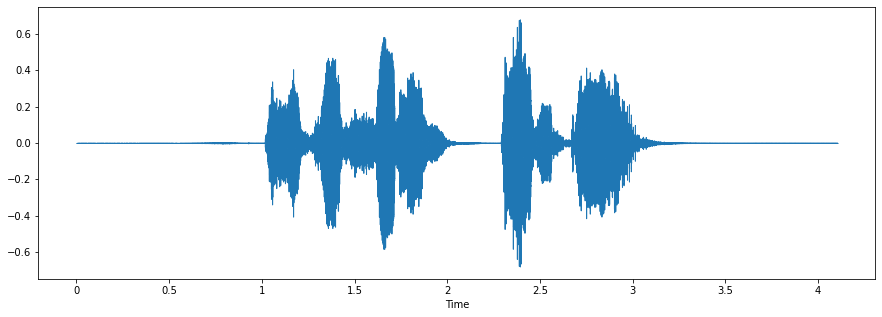

In [ ]:
# Angry - Actor 21
filename = '/content/dataset/Actor_21/03-01-05-02-02-01-21.wav'  
data, sampling_rate = librosa.load(filename)

plt.figure(figsize = (15, 5))
librosa.display.waveshow(data, sr = sampling_rate)

ipd.Audio(filename)

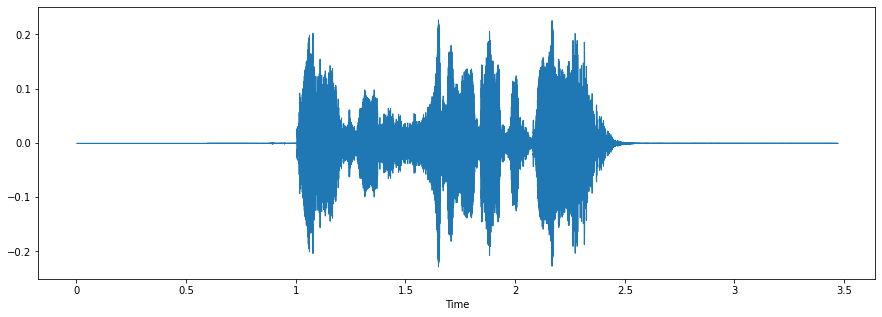

In [ ]:
# Disgust - Actor 4
filename = '/content/dataset/Actor_04/03-01-08-02-02-01-04.wav'  
data, sampling_rate = librosa.load(filename)

plt.figure(figsize = (15, 5))
librosa.display.waveshow(data, sr = sampling_rate)

ipd.Audio(filename)

We can already notice a few things:
*   The duration is about 4 seconds.
*   There are some moments of silence at the beginning and at the end. We may remove them by picking just the central seconds.

Now, let's check the duration and the sampling rate for each statement.

In [ ]:
duration = []
rate = []
for filename in df['path']:
  data, sampling_rate = librosa.load(filename, sr = 48000) # We want the native sr
  duration.append(data.shape[0])
  rate.append(sampling_rate)
print(np.unique(duration))
print(np.unique(rate))

[140941 142542 144144 145745 145746 147347 147348 148949 150550 150551
 152152 153753 153754 155355 155356 156956 156957 158558 158559 160160
 161761 161762 163363 163364 164964 164965 166566 166567 168168 169769
 169770 171371 171372 172972 172973 174574 174575 176176 177777 177778
 179379 179380 180980 180981 182582 182583 184184 185785 185786 187387
 187388 188988 188989 190590 190591 192192 193793 193794 195395 195396
 196996 196997 198598 198599 200200 201801 201802 203403 203404 205004
 205005 206606 206607 208208 209809 209810 211411 211412 213013 214614
 214615 216216 217817 217818 219419 219420 221020 221021 222622 222623
 224224 227427 229028 229029 230630 230631 232232 233834 235435 237037
 240240 245045 253053]
[48000]


The rate is the same for each sample. Let's have a better view of the durations.

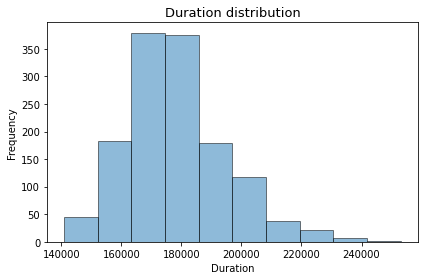

In [ ]:
plt.title('Duration distribution', fontsize = 13)
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.hist(duration, alpha = 0.5, histtype = 'bar', ec = 'black')
plt.tight_layout()
plt.show() 

Duration in seconds = duration / 48000 (sample rate).

In [ ]:
print(round(np.mean(duration), 2))
print(np.min(duration))
print(np.max(duration))

178309.1
140941
253053


Seems like we have a mean of ~180000 and a duration span of ~45000.

# Data processing

First of all, we cut the first and the last part of each sample in order to have a uniform duration of 3 seconds. 

In [ ]:
audio = []
for filename in df['path']:
  data, sampling_rate = librosa.load(filename, sr = 48000, duration = 3, offset = 0.5) # We want the native sr
  audio.append(data)
df = pd.DataFrame(np.column_stack([df, audio]))
df.columns = ['emotion', 'path', 'data']

In [ ]:
df.head()

,emotion,path,data
0,surprise,/content/dataset/Actor_01/03-01-08-01-01-02-01...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,happy,/content/dataset/Actor_01/03-01-03-02-01-01-01...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,angry,/content/dataset/Actor_01/03-01-05-01-02-01-01...,"[9.1552734e-05, 3.0517578e-05, 0.0, -3.0517578..."
3,happy,/content/dataset/Actor_01/03-01-03-01-01-02-01...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,happy,/content/dataset/Actor_01/03-01-03-01-01-01-01...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


We pad with zeros the audio with length < 144000.

In [12]:
for i in range(len(df)):
  if(len(df['data'][i]) != 144000):
    start_pad = (144000 - len(df['data'][i]))//2
    end_pad = 144000 - len(df['data'][i]) - start_pad
    df['data'][i] = np.pad(df['data'][i], (start_pad, end_pad), mode = 'constant')

In [ ]:
for i in range(len(df)):
  if(len(df['data'][i]) != 144000):
    print(len(df['data'][i]))

## Feature extraction

We extract the log Mel spectrogram.

In [13]:
def feature_extractor(input, feature, sr = 48000):
  # Mel Spectrogram
  if(feature == 'mel'):
    x = librosa.power_to_db(librosa.feature.melspectrogram(input*1.0, sr = sr, n_fft = 1024, n_mels = 128, fmin = 50, fmax = 24000))
    return np.mean(x, axis = 0)              

In [14]:
df['features'] = [0] * 1344
for i in range(len(df)):
  mel = feature_extractor(df['data'][i], 'mel')
  df['features'][i] = np.array(mel, dtype = object)

In [15]:
print('We obtained a matrix with ' + str(len(df)) + ' samples and ' + str(len(df['features'][0])) + ' features.')

We obtained a matrix with 1344 samples and 282 features.


We already split the dataset into training and test, in order to perform augmentation only on the training set. We use actors 21-24 for test.

In [16]:
X_test = df['features'][1120:1344]
y_test = df['emotion'][1120:1344]
X_test.reset_index(inplace = True, drop = True)
y_test.reset_index(inplace = True, drop = True)

In [17]:
df = df[:1120]

## Data augmentation

This phase is performed in the following way;
1.   We add noise for all the signals.
2.   We pitch all the signals.
3.   We stretch all the signals.
4.   We shift all the signals.

In the end, we'll have the following data:
*   Original dataset.
*   Noise dataset.
*   Pitch dataset.
*   Stretch dataset.
*   Shift dataset.

### Noise

In [18]:
noise = audiomentations.Compose([
    audiomentations.AddGaussianNoise(p = 1)
])

In [19]:
df['features_aug1'] = [0] * 1120
for i in range(len(df)):
  augmented_samples = noise(df['data'][i], 48000)
  mel = feature_extractor(augmented_samples, 'mel')
  df['features_aug1'][i] = np.array(mel, dtype = object)

### Pitch

In [20]:
pitchShift = audiomentations.Compose([
    audiomentations.PitchShift(p = 1)
])

In [21]:
df['features_aug2'] = [0] * 1120
for i in range(len(df)):
  augmented_samples = pitchShift(df['data'][i], 48000)
  mel = feature_extractor(augmented_samples, 'mel')
  df['features_aug2'][i] = np.array(mel, dtype = object)

<ipython-input-21-7bc156d41492>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['features_aug2'][i] = np.array(mel, dtype = object)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### Stretch

In [22]:
stretch = audiomentations.Compose([
    audiomentations.TimeStretch(p = 1)
])

In [23]:
df['features_aug3'] = [0] * 1120
for i in range(len(df)):
  augmented_samples = stretch(df['data'][i], 48000)
  mel = feature_extractor(augmented_samples, 'mel')
  df['features_aug3'][i] = np.array(mel, dtype = object)

<ipython-input-23-dc5192089947>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['features_aug3'][i] = np.array(mel, dtype = object)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### Shift

In [24]:
shift = audiomentations.Compose([
    audiomentations.Shift(min_fraction = 0.25, max_fraction = 0.25, rollover = False, p = 1)
])

In [25]:
df['features_aug4'] = [0] * 1120
for i in range(len(df)):  
  augmented_samples = shift(df['data'][i], 48000)
  mel = feature_extractor(augmented_samples, 'mel')
  df['features_aug4'][i] = np.array(mel, dtype = object)

<ipython-input-25-d653270d1730>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['features_aug4'][i] = np.array(mel, dtype = object)


Let's put together all the features with the related labels.

In [26]:
final_df = pd.concat([
    pd.concat([df['path'], df['path'], df['path'], df['path'], df['path']], axis = 0),
    pd.concat([df['emotion'], df['emotion'], df['emotion'], df['emotion'], df['emotion']], axis = 0),
    pd.concat([df['data'], df['data'], df['data'], df['data'], df['data']], axis = 0),
    pd.concat([df['features'], df['features_aug1'], df['features_aug2'], df['features_aug3'], df['features_aug4']], axis = 0)
], axis = 1)
final_df.rename(columns = {0: 'features'}, inplace = True)
final_df.reset_index (drop = True, inplace = True)

In [ ]:
final_df.head()

,path,emotion,data,features
0,/content/dataset/Actor_01/03-01-08-01-01-02-01...,surprise,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-80.2764663696289, -80.2764663696289, -80.276..."
1,/content/dataset/Actor_01/03-01-03-02-01-01-01...,happy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-74.78968048095703, -74.89425659179688, -74.9..."
2,/content/dataset/Actor_01/03-01-05-01-02-01-01...,angry,"[9.1552734e-05, 3.0517578e-05, 0.0, -3.0517578...","[-69.76966094970703, -70.14131164550781, -70.1..."
3,/content/dataset/Actor_01/03-01-03-01-01-02-01...,happy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-76.3656234741211, -76.3656234741211, -76.335..."
4,/content/dataset/Actor_01/03-01-03-01-01-01-01...,happy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-80.67929077148438, -80.67929077148438, -80.6..."


In [27]:
print('We obtained a matrix with ' + str(len(final_df)) + ' samples and ' + str(len(final_df['features'][0])) + ' features.')

We obtained a matrix with 5600 samples and 282 features.


## Split train-test

Now we normalize the data.

In [28]:
X_train =  final_df['features'].tolist()
y_train = final_df['emotion'].tolist()
X_test = X_test.tolist()
y_test = y_test.tolist()

In [29]:
for i in range(len(X_train)):
  X_train[i] = X_train[i].astype(np.float64)
for i in range(len(X_test)):
  X_test[i] = X_test[i].astype(np.float64)

scaler = StandardScaler()
X_train[:1120] = scaler.fit_transform(X_train[:1120])
X_train[1120:] = scaler.transform(X_train[1120:])
X_test = scaler.transform(X_test)

In [30]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [31]:
# One-hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [32]:
# Making data compatible for the model
X_train = np.expand_dims(X_train, axis = 2)
X_test = np.expand_dims(X_test, axis = 2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5600, 282, 1), (5600, 7), (224, 282, 1), (224, 7))

# Model selection

## Model 0: vanilla data

In this preliminary model we use the data "vanilla" (i.e. not augmented).

In [33]:
X_train_vanilla = X_train[:896]
y_train_vanilla = y_train[:896]
X_val = X_train[896:1120]
y_val = y_train[896:1120]
X_train_vanilla.shape, y_train_vanilla.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((896, 282, 1), (896, 7), (224, 282, 1), (224, 7), (224, 282, 1), (224, 7))

We instanciate our first model with 3 Conv1D layers, 2 Dense layers, ReLU activations and MaxPooling1D. The output will be provided by the softmax function.

In [34]:
num_classes = 7

model0 = Sequential()

model0.add(Conv1D(64, kernel_size = (10), activation = 'relu', input_shape = (282, 1)))

model0.add(Conv1D(128, kernel_size = (10), activation = 'relu'))
model0.add(MaxPooling1D(pool_size = (8)))

model0.add(Conv1D(128, kernel_size = (10), activation = 'relu'))
model0.add(MaxPooling1D(pool_size = (8)))

model0.add(Flatten())
model0.add(Dense(128, activation = 'relu'))

model0.add(Dense(num_classes, activation = 'softmax'))

model0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 273, 64)           704       
                                                                 
 conv1d_1 (Conv1D)           (None, 264, 128)          82048     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 33, 128)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 24, 128)           163968    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 3, 128)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 384)               0

In [35]:
stop_early = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

In [36]:
model0.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
history0 = model0.fit(X_train_vanilla, y_train_vanilla, batch_size = 32, epochs = 100, validation_data = (X_val, y_val), callbacks = [stop_early])

Epoch 1/100
28/28 [==============================] - 9s 14ms/step - loss: 1.7390 - accuracy: 0.2980 - val_loss: 1.6577 - val_accuracy: 0.3705
Epoch 2/100
28/28 [==============================] - 0s 7ms/step - loss: 1.5409 - accuracy: 0.3906 - val_loss: 1.6372 - val_accuracy: 0.3705
Epoch 3/100
28/28 [==============================] - 0s 6ms/step - loss: 1.4542 - accuracy: 0.4152 - val_loss: 1.5999 - val_accuracy: 0.3795
Epoch 4/100
28/28 [==============================] - 0s 6ms/step - loss: 1.3372 - accuracy: 0.4833 - val_loss: 1.6755 - val_accuracy: 0.3304
Epoch 5/100
28/28 [==============================] - 0s 6ms/step - loss: 1.2771 - accuracy: 0.5067 - val_loss: 1.5355 - val_accuracy: 0.3839
Epoch 6/100
28/28 [==============================] - 0s 5ms/step - loss: 1.1065 - accuracy: 0.5792 - val_loss: 1.6957 - val_accuracy: 0.3304
Epoch 7/100
28/28 [==============================] - 0s 6ms/step - loss: 0.9764 - accuracy: 0.6462 - val_loss: 1.7775 - val_accuracy: 0.4286
Epoch 8/100


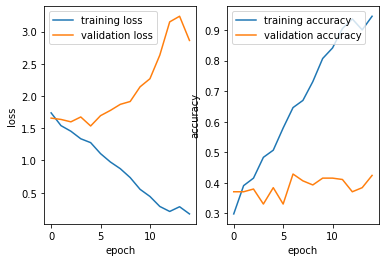

In [37]:
plt.subplot(1,2,1)
plt.plot(history0.history['loss'])
plt.plot(history0.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training loss', 'validation loss'])

plt.subplot(1,2,2)
plt.plot(history0.history['accuracy'])
plt.plot(history0.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy'])

In [38]:
y_pred = model0.predict(X_val)
y_pred_ = np.argmax(y_pred, axis = 1)
y_val_ = np.argmax(y_val, axis = 1)
print(classification_report(y_val_, y_pred_))

7/7 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.46      0.50      0.48        32
           1       0.47      0.56      0.51        32
           2       0.72      0.81      0.76        32
           3       0.26      0.19      0.22        32
           4       0.22      0.06      0.10        32
           5       0.20      0.25      0.22        32
           6       0.23      0.31      0.27        32

    accuracy                           0.38       224
   macro avg       0.37      0.38      0.37       224
weighted avg       0.37      0.38      0.37       224



Mapping:
0. Angry.
1. Calm.
2. Disgust.
3. Fear.
4. Happy.
5. Sad.
6. Surprise.

Text(0, 0.5, 'Prediction')

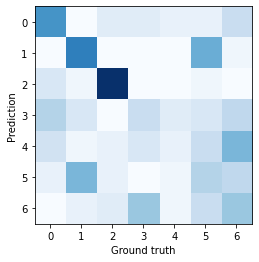

In [39]:
cm = confusion_matrix(y_val_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [40]:
print(top_k_accuracy_score(y_val_, y_pred, k = 2))
print(top_k_accuracy_score(y_val_, y_pred, k = 3))

0.6473214285714286
0.7678571428571429


We notice a very high overfitting.

## Grid search CV

Now we can perform a grid search on various hyperparameters. In particular, this search is performed on the basis of a 5-Folds Cross-Validation. For each fold, the validation set is composed by 4 different actors.

In [ ]:
alpha = [0.00, 0.01]
learning_rate = [0.0001, 0.001]
dropout = [0.3, 0.4, 0.5]
k_reg = [0.01, 0.001]
b_reg = [0.01, 0.001]

params = [{'alpha': item[0],
           'learning_rate': item[1],
           'dropout': item[2],
           'k_reg': item[3],
           'b_reg': item[4]
            } for item in
              list(itertools.product(*[alpha,
                                       learning_rate,
                                       dropout,
                                       k_reg,
                                       b_reg]))
          ]

In [ ]:
# Splitting dataset into 5 folds
X_train_CV = []
y_train_CV = []
X_val_CV= []
y_val_CV = []
X_train_ = np.concatenate((X_train_vanilla, X_val), axis = 0)
y_train_ = np.concatenate((y_train_vanilla, y_val), axis = 0)
for i in range(0, 5):
  start = i*4*56
  end = start + 224
  index =  list(range(start, end))
  X_val_CV.append(X_train_[start:end])
  y_val_CV.append(y_train_[start:end])
  X_train_CV.append(np.concatenate((X_train_[0:start], X_train_[end:1120]), axis = 0))
  y_train_CV.append(np.concatenate((y_train_[0:start], y_train_[end:1120]), axis = 0))

In [ ]:
for i in X_train_CV:
  print(i.shape)

(896, 282, 1)
(896, 282, 1)
(896, 282, 1)
(896, 282, 1)
(896, 282, 1)


In [ ]:
results = []
stop_early = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)
for param in params:
  score1 = []
  score2 = []
  score3 = []
  for i in range(5):
    num_classes = 7

    modelCV = Sequential()

    modelCV.add(Conv1D(64, kernel_size = (10), input_shape = (282, 1)))
    modelCV.add(LeakyReLU(param['alpha']))

    modelCV.add(Conv1D(128, kernel_size = (10), kernel_regularizer = l2(param['k_reg']), bias_regularizer = l2(param['b_reg'])))
    modelCV.add(LeakyReLU(param['alpha']))
    modelCV.add(MaxPooling1D(pool_size = (8)))
    modelCV.add(Dropout(param['dropout']))

    modelCV.add(Conv1D(128, kernel_size = (10), kernel_regularizer = l2(param['k_reg']), bias_regularizer = l2(param['b_reg'])))
    modelCV.add(LeakyReLU(param['alpha']))
    modelCV.add(MaxPooling1D(pool_size = (8)))
    modelCV.add(Dropout(param['dropout']))
    modelCV.add(Flatten())

    modelCV.add(Dense(128, kernel_regularizer = l2(param['k_reg']), bias_regularizer = l2(param['b_reg'])))
    modelCV.add(LeakyReLU(param['alpha']))
    modelCV.add(Dropout(param['dropout']))

    modelCV.add(Dense(num_classes, activation = 'softmax'))

    modelCV.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = param['learning_rate']), metrics = ['accuracy'])
    historyCV = modelCV.fit(X_train_CV[i], y_train_CV[i], batch_size = 32, epochs = 75, validation_data = (X_val_CV[i], y_val_CV[i]), callbacks = [stop_early], verbose = 0)
    
    res = modelCV.evaluate(X_val_CV[i], y_val_CV[i], verbose = 0)
    score1.append(res[0])
    score2.append(res[1])
    y_pred = modelCV.predict(X_val_CV[i], verbose = 0)
    y_val_ = np.argmax(y_val_CV[i], axis = 1)
    score3.append(top_k_accuracy_score(y_val_, y_pred, k = 3))

  results.append([str(param) + ' ' + str(np.around(np.mean(score1), 3)) + ' ' + str(np.around(np.mean(score2), 3)) + ' ' + str(np.around(np.mean(score3), 3))])

In [ ]:
results

Seems like the best model has the following hyperparameters:

* alpha: 0.0,
* learning_rate: 0.001,
* dropout: 0.5,
* k_reg: 0.001,
* b_reg: 0.001.

Best loss: 1.584.
Top-1 accuracy: 47%.
Top-3 accuracy: 82.2%

Let's build this model.

## Model 1: fine-tuned

In [41]:
num_classes = 7

model1 = Sequential()

model1.add(Conv1D(64, kernel_size = (10), activation = 'relu', input_shape = (282, 1)))

model1.add(Conv1D(128, kernel_size = (10), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.001)))
model1.add(MaxPooling1D(pool_size = (8)))
model1.add(Dropout(0.5))

model1.add(Conv1D(128, kernel_size = (10), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.001)))
model1.add(MaxPooling1D(pool_size = (8)))
model1.add(Dropout(0.5))
model1.add(Flatten())

model1.add(Dense(128, activation = 'relu'))
model1.add(Dropout(0.5))

model1.add(Dense(num_classes, activation = 'softmax'))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 273, 64)           704       
                                                                 
 conv1d_4 (Conv1D)           (None, 264, 128)          82048     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 33, 128)          0         
 1D)                                                             
                                                                 
 dropout (Dropout)           (None, 33, 128)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 24, 128)           163968    
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 3, 128)           0         
 1D)                                                  

In [42]:
stop_early = EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights = True)

In [43]:
model1.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
history1 = model1.fit(X_train_vanilla, y_train_vanilla, batch_size = 32, epochs = 200, validation_data = (X_val, y_val), callbacks = [stop_early])

Epoch 1/200
28/28 [==============================] - 1s 14ms/step - loss: 2.0757 - accuracy: 0.2333 - val_loss: 1.9783 - val_accuracy: 0.2723
Epoch 2/200
28/28 [==============================] - 0s 8ms/step - loss: 1.9446 - accuracy: 0.2913 - val_loss: 1.9061 - val_accuracy: 0.2991
Epoch 3/200
28/28 [==============================] - 0s 7ms/step - loss: 1.8875 - accuracy: 0.3147 - val_loss: 1.8498 - val_accuracy: 0.3259
Epoch 4/200
28/28 [==============================] - 0s 6ms/step - loss: 1.8438 - accuracy: 0.3147 - val_loss: 1.8083 - val_accuracy: 0.3393
Epoch 5/200
28/28 [==============================] - 0s 6ms/step - loss: 1.7912 - accuracy: 0.3527 - val_loss: 1.7626 - val_accuracy: 0.3884
Epoch 6/200
28/28 [==============================] - 0s 6ms/step - loss: 1.7666 - accuracy: 0.3583 - val_loss: 1.7343 - val_accuracy: 0.4062
Epoch 7/200
28/28 [==============================] - 0s 6ms/step - loss: 1.7191 - accuracy: 0.3683 - val_loss: 1.6929 - val_accuracy: 0.3750
Epoch 8/200


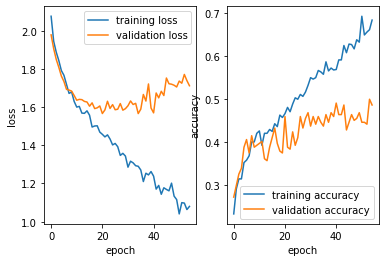

In [44]:
plt.subplot(1,2,1)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training loss', 'validation loss'])

plt.subplot(1,2,2)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy'])

In [45]:
y_pred = model1.predict(X_val)
y_pred_ = np.argmax(y_pred, axis = 1)
y_val_ = np.argmax(y_val, axis = 1)
print(classification_report(y_val_, y_pred_))

7/7 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.59      0.41      0.48        32
           1       0.53      0.50      0.52        32
           2       0.57      0.91      0.70        32
           3       0.42      0.25      0.31        32
           4       0.29      0.16      0.20        32
           5       0.33      0.47      0.38        32
           6       0.36      0.44      0.39        32

    accuracy                           0.45       224
   macro avg       0.44      0.45      0.43       224
weighted avg       0.44      0.45      0.43       224



Mapping:
0. Angry.
1. Calm.
2. Disgust.
3. Fear.
4. Happy.
5. Sad.
6. Surprise.

Text(0, 0.5, 'Prediction')

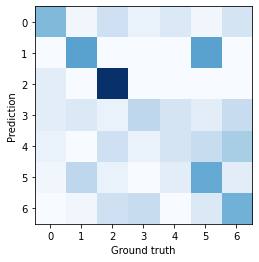

In [46]:
cm = confusion_matrix(y_val_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [47]:
print(top_k_accuracy_score(y_val_, y_pred, k = 2))
print(top_k_accuracy_score(y_val_, y_pred, k = 3))

0.6830357142857143
0.7946428571428571


## Model 2: augmented data

Now let's return to the original model and compare the performances if we use augmented data.

In [48]:
# We don't have to pick the validation data augmented
X_train_aug = np.concatenate((X_train[0:896], X_train[1120:1120+896], X_train[2240:2240+896], 
                                  X_train[3360:3360+896], X_train[4480:4480+896]
                                  ), axis = 0)
y_train_aug = np.concatenate((y_train[0:896], y_train[1120:1120+896], y_train[2240:2240+896], 
                                  y_train[3360:3360+896],y_train[4480:4480+896]
                                  ), axis = 0)

In [49]:
num_classes = 7

model2 = Sequential()

model2.add(Conv1D(64, kernel_size = (10), activation = 'relu', input_shape = (282, 1)))

model2.add(Conv1D(128, kernel_size = (10), activation = 'relu'))
model2.add(MaxPooling1D(pool_size = (8)))

model2.add(Conv1D(128, kernel_size = (10), activation = 'relu'))
model2.add(MaxPooling1D(pool_size = (8)))

model2.add(Flatten())
model2.add(Dense(128, activation = 'relu'))

model2.add(Dense(num_classes, activation = 'softmax'))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 273, 64)           704       
                                                                 
 conv1d_7 (Conv1D)           (None, 264, 128)          82048     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 33, 128)          0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 24, 128)           163968    
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 3, 128)           0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 384)              

In [50]:
stop_early = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

In [51]:
model2.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
history2 = model2.fit(X_train_aug, y_train_aug, batch_size = 32, epochs = 100, validation_data = (X_val, y_val), callbacks = [stop_early])

Epoch 1/100
140/140 [==============================] - 1s 6ms/step - loss: 1.6980 - accuracy: 0.3134 - val_loss: 1.5600 - val_accuracy: 0.3705
Epoch 2/100
140/140 [==============================] - 1s 4ms/step - loss: 1.4978 - accuracy: 0.4056 - val_loss: 1.4475 - val_accuracy: 0.4330
Epoch 3/100
140/140 [==============================] - 1s 5ms/step - loss: 1.3450 - accuracy: 0.4670 - val_loss: 1.4481 - val_accuracy: 0.4464
Epoch 4/100
140/140 [==============================] - 1s 5ms/step - loss: 1.1710 - accuracy: 0.5509 - val_loss: 1.4625 - val_accuracy: 0.4196
Epoch 5/100
140/140 [==============================] - 1s 5ms/step - loss: 1.0156 - accuracy: 0.6147 - val_loss: 1.7989 - val_accuracy: 0.4464
Epoch 6/100
140/140 [==============================] - 1s 4ms/step - loss: 0.8929 - accuracy: 0.6623 - val_loss: 1.7535 - val_accuracy: 0.4420
Epoch 7/100
140/140 [==============================] - 1s 4ms/step - loss: 0.7377 - accuracy: 0.7342 - val_loss: 1.9756 - val_accuracy: 0.4821

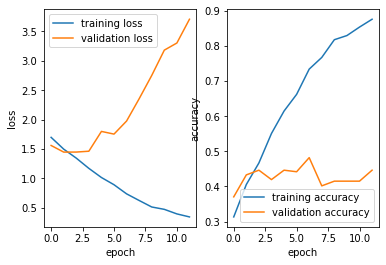

In [52]:
plt.subplot(1,2,1)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training loss', 'validation loss'])

plt.subplot(1,2,2)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy'])

In [53]:
y_pred = model2.predict(X_val)
y_pred_ = np.argmax(y_pred, axis = 1)
y_val_ = np.argmax(y_val, axis = 1)
print(classification_report(y_val_, y_pred_))

7/7 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.43      0.41      0.42        32
           1       0.51      0.69      0.59        32
           2       0.53      0.88      0.66        32
           3       0.39      0.41      0.40        32
           4       0.31      0.16      0.21        32
           5       0.17      0.12      0.15        32
           6       0.46      0.38      0.41        32

    accuracy                           0.43       224
   macro avg       0.40      0.43      0.40       224
weighted avg       0.40      0.43      0.40       224



Mapping:
0. Angry.
1. Calm.
2. Disgust.
3. Fear.
4. Happy.
5. Sad.
6. Surprise.

Text(0, 0.5, 'Prediction')

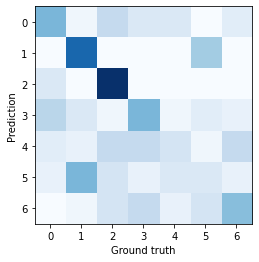

In [54]:
cm = confusion_matrix(y_val_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [55]:
print(top_k_accuracy_score(y_val_, y_pred, k = 2))
print(top_k_accuracy_score(y_val_, y_pred, k = 3))

0.6383928571428571
0.7767857142857143


## Grid search CV

Let's perform a grid search on the basis of a 5-Folds Cross-Validation in the same way as above.

In [ ]:
alpha = [0.00, 0.01]
learning_rate = [0.0001, 0.001]
dropout = [0.3, 0.4, 0.5]
k_reg = [0.01, 0.001]
b_reg = [0.01, 0.001]

params = [{'alpha': item[0],
           'learning_rate': item[1],
           'dropout': item[2],
           'k_reg': item[3],
           'b_reg': item[4]
            } for item in
              list(itertools.product(*[alpha,
                                       learning_rate,
                                       dropout,
                                       k_reg,
                                       b_reg]))
          ]

In [ ]:
# Splitting dataset into 5 folds
X_train_CV = []
y_train_CV = []
X_val_CV= []
y_val_CV = []

for i in range(5):
  start = i*4*56
  end = start + 224
  index =  list(range(start, end))
  X_val_CV.append(X_train[start:end])
  y_val_CV.append(y_train[start:end])
  to_remove = list(range(start, end)) + list(range(start+1120, end+1120)) + list(range(start+2240, end+2240)) + list(range(start+3360, end+3360)) + list(range(start+4480, end+4480)) 
  # We don't have to pick the validation data augmented
  X_train_CV.append(np.delete(X_train, to_remove, axis = 0))
  y_train_CV.append(np.delete(y_train, to_remove, axis = 0))

In [ ]:
for i in X_train_CV:
  print(i.shape)

(4480, 282, 1)
(4480, 282, 1)
(4480, 282, 1)
(4480, 282, 1)
(4480, 282, 1)


In [ ]:
results = []
stop_early = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)
for param in params:
  score1 = []
  score2 = []
  score3 = []
  for i in range(5):
    num_classes = 7

    modelCVaug = Sequential()

    modelCVaug.add(Conv1D(64, kernel_size = (10), input_shape = (282, 1)))
    modelCVaug.add(LeakyReLU(param['alpha']))

    modelCVaug.add(Conv1D(128, kernel_size = (10), kernel_regularizer = l2(param['k_reg']), bias_regularizer = l2(param['k_reg'])))
    modelCVaug.add(LeakyReLU(param['alpha']))
    modelCVaug.add(MaxPooling1D(pool_size = (8)))
    modelCVaug.add(Dropout(param['dropout']))

    modelCVaug.add(Conv1D(128, kernel_size = (10), kernel_regularizer = l2(param['k_reg']), bias_regularizer = l2(param['k_reg'])))
    modelCVaug.add(LeakyReLU(param['alpha']))
    modelCVaug.add(MaxPooling1D(pool_size = (8)))
    modelCVaug.add(Dropout(param['dropout']))
    modelCVaug.add(Flatten())

    modelCVaug.add(Dense(128, kernel_regularizer = l2(param['k_reg']), bias_regularizer = l2(param['k_reg'])))
    modelCVaug.add(LeakyReLU(param['alpha']))
    modelCVaug.add(Dropout(param['dropout']))

    modelCVaug.add(Dense(num_classes, activation = 'softmax'))

    modelCVaug.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = param['learning_rate']), metrics = ['accuracy'])
    historyCVaug = modelCVaug.fit(X_train_CV[i], y_train_CV[i], batch_size = 32, epochs = 75, validation_data = (X_val_CV[i], y_val_CV[i]), callbacks = [stop_early], verbose = 0)

    res = modelCVaug.evaluate(X_val_CV[i], y_val_CV[i], verbose = 0)
    score1.append(res[0])
    score2.append(res[1])
    y_pred = modelCVaug.predict(X_val_CV[i], verbose = 0)
    y_val_ = np.argmax(y_val_CV[i], axis = 1)
    score3.append(top_k_accuracy_score(y_val_, y_pred, k = 3))
  results.append([str(param) + ' ' + str(np.around(np.mean(score1), 3)) + ' ' + str(np.around(np.mean(score2), 3)) + ' ' + str(np.around(np.mean(score3), 3))])

In [ ]:
results

Seems like the best model has the following hyperparameters:

* alpha: 0.0,
* learning_rate: 0.001,
* dropout: 0.5,
* k_reg: 0.001,
* b_reg: 0.01.

Best loss: 1.529.
Top-1 accuracy: 49.8%.
Top-3 accuracy: 82.4%

Let's build this model.

## Model 3: fine-tuned aug

In [56]:
# We don't have to pick the validation data augmented
X_train_aug = np.concatenate((X_train[0:896], X_train[1120:1120+896], X_train[2240:2240+896], 
                                  X_train[3360:3360+896], X_train[4480:4480+896]
                                  ), axis = 0)
y_train_aug = np.concatenate((y_train[0:896], y_train[1120:1120+896], y_train[2240:2240+896], 
                                  y_train[3360:3360+896],y_train[4480:4480+896]
                                  ), axis = 0)

In [57]:
num_classes = 7

model3 = Sequential()

model3.add(Conv1D(64, kernel_size = (10), activation = 'relu', input_shape = (282, 1)))

model3.add(Conv1D(128, kernel_size = (10), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model3.add(MaxPooling1D(pool_size = (8)))
model3.add(Dropout(0.5))

model3.add(Conv1D(128, kernel_size = (10), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model3.add(MaxPooling1D(pool_size = (8)))
model3.add(Dropout(0.5))
model3.add(Flatten())

model3.add(Dense(128, activation = 'relu'))
model3.add(Dropout(0.5))

model3.add(Dense(num_classes, activation = 'softmax'))

model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 273, 64)           704       
                                                                 
 conv1d_10 (Conv1D)          (None, 264, 128)          82048     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 33, 128)          0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 33, 128)           0         
                                                                 
 conv1d_11 (Conv1D)          (None, 24, 128)           163968    
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 3, 128)           0         
 1D)                                                  

In [58]:
stop_early = EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights = True)

In [59]:
model3.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
history3 = model3.fit(X_train_aug, y_train_aug, batch_size = 32, epochs = 200, validation_data = (X_val, y_val), callbacks = [stop_early])

Epoch 1/200
140/140 [==============================] - 2s 7ms/step - loss: 2.0443 - accuracy: 0.2228 - val_loss: 1.8823 - val_accuracy: 0.3125
Epoch 2/200
140/140 [==============================] - 1s 5ms/step - loss: 1.8696 - accuracy: 0.2806 - val_loss: 1.7220 - val_accuracy: 0.3482
Epoch 3/200
140/140 [==============================] - 1s 5ms/step - loss: 1.7834 - accuracy: 0.3308 - val_loss: 1.6518 - val_accuracy: 0.4107
Epoch 4/200
140/140 [==============================] - 1s 5ms/step - loss: 1.7164 - accuracy: 0.3451 - val_loss: 1.5905 - val_accuracy: 0.4286
Epoch 5/200
140/140 [==============================] - 1s 5ms/step - loss: 1.6790 - accuracy: 0.3665 - val_loss: 1.5739 - val_accuracy: 0.4196
Epoch 6/200
140/140 [==============================] - 1s 5ms/step - loss: 1.6528 - accuracy: 0.3757 - val_loss: 1.5493 - val_accuracy: 0.4196
Epoch 7/200
140/140 [==============================] - 1s 5ms/step - loss: 1.6320 - accuracy: 0.3839 - val_loss: 1.5244 - val_accuracy: 0.4286

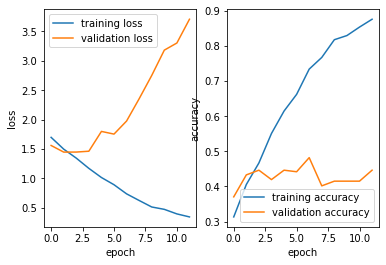

In [60]:
plt.subplot(1,2,1)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training loss', 'validation loss'])

plt.subplot(1,2,2)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training accuracy', 'validation accuracy'])

In [61]:
y_pred = model3.predict(X_val)
y_pred_ = np.argmax(y_pred, axis = 1)
y_val_ = np.argmax(y_val, axis = 1)
print(classification_report(y_val_, y_pred_))

7/7 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.54      0.44      0.48        32
           1       0.56      0.88      0.68        32
           2       0.56      0.84      0.68        32
           3       0.55      0.38      0.44        32
           4       0.18      0.12      0.15        32
           5       0.06      0.03      0.04        32
           6       0.38      0.47      0.42        32

    accuracy                           0.45       224
   macro avg       0.40      0.45      0.41       224
weighted avg       0.40      0.45      0.41       224



Mapping:
0. Angry.
1. Calm.
2. Disgust.
3. Fear.
4. Happy.
5. Sad.
6. Surprise.

Text(0, 0.5, 'Prediction')

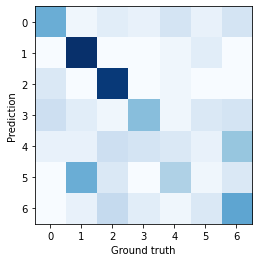

In [62]:
cm = confusion_matrix(y_val_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [63]:
print(top_k_accuracy_score(y_val_, y_pred, k = 2))
print(top_k_accuracy_score(y_val_, y_pred, k = 3))

0.65625
0.78125


# Saving and testing

Now we may merge training set and validation set in order to re-train all of our models on a bigger set of data. Then, we'll test the performances on the test set.

## Model 0

In [64]:
X_train_vanilla = X_train[:1120]
y_train_vanilla = y_train[:1120]

In [68]:
num_classes = 7

model0 = Sequential()

model0.add(Conv1D(64, kernel_size = (10), activation = 'relu', input_shape = (282, 1)))

model0.add(Conv1D(128, kernel_size = (10), activation = 'relu'))
model0.add(MaxPooling1D(pool_size = (8)))

model0.add(Conv1D(128, kernel_size = (10), activation = 'relu'))
model0.add(MaxPooling1D(pool_size = (8)))

model0.add(Flatten())
model0.add(Dense(128, activation = 'relu'))

model0.add(Dense(num_classes, activation = 'softmax'))

In [69]:
model0.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
history0 = model0.fit(X_train_vanilla, y_train_vanilla, batch_size = 32, epochs = 10, verbose = 0)

In [70]:
y_pred = model0.predict(X_test)
y_pred_ = np.argmax(y_pred, axis = 1)
y_test_ = np.argmax(y_test, axis = 1)
print(classification_report(y_test_, y_pred_))

7/7 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.41      0.38      0.39        32
           1       0.75      0.56      0.64        32
           2       0.41      0.72      0.52        32
           3       0.29      0.06      0.10        32
           4       0.39      0.34      0.37        32
           5       0.19      0.09      0.12        32
           6       0.34      0.69      0.46        32

    accuracy                           0.41       224
   macro avg       0.40      0.41      0.37       224
weighted avg       0.40      0.41      0.37       224



Text(0, 0.5, 'Prediction')

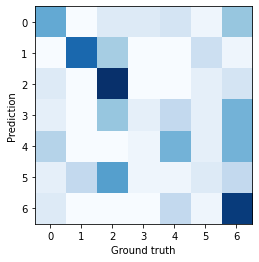

In [71]:
cm = confusion_matrix(y_test_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [72]:
print(top_k_accuracy_score(y_test_, y_pred, k = 2))
print(top_k_accuracy_score(y_test_, y_pred, k = 3))

0.6383928571428571
0.7901785714285714


In [73]:
model0.save('/content/gdrive/MyDrive/Digital Signal/Models/Audio - CNN 1D/model0.h5')

## Model 1

In [74]:
num_classes = 7

model1 = Sequential()

model1.add(Conv1D(64, kernel_size = (10), activation = 'relu', input_shape = (282, 1)))

model1.add(Conv1D(128, kernel_size = (10), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.001)))
model1.add(MaxPooling1D(pool_size = (8)))
model1.add(Dropout(0.5))

model1.add(Conv1D(128, kernel_size = (10), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.001)))
model1.add(MaxPooling1D(pool_size = (8)))
model1.add(Dropout(0.5))
model1.add(Flatten())

model1.add(Dense(128, activation = 'relu'))
model1.add(Dropout(0.5))

model1.add(Dense(num_classes, activation = 'softmax'))

In [75]:
model1.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
history1 = model1.fit(X_train_vanilla, y_train_vanilla, batch_size = 32, epochs = 40, verbose = 0)

In [76]:
y_pred = model1.predict(X_test)
y_pred_ = np.argmax(y_pred, axis = 1)
y_test_ = np.argmax(y_test, axis = 1)
print(classification_report(y_test_, y_pred_))

7/7 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.52      0.50      0.51        32
           1       0.63      0.75      0.69        32
           2       0.43      0.88      0.58        32
           3       0.30      0.09      0.14        32
           4       0.27      0.19      0.22        32
           5       0.33      0.19      0.24        32
           6       0.40      0.50      0.44        32

    accuracy                           0.44       224
   macro avg       0.41      0.44      0.40       224
weighted avg       0.41      0.44      0.40       224



Text(0, 0.5, 'Prediction')

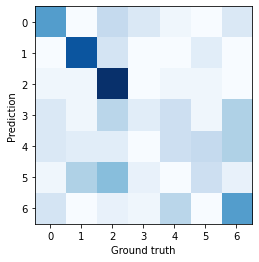

In [77]:
cm = confusion_matrix(y_test_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [78]:
print(top_k_accuracy_score(y_test_, y_pred, k = 2))
print(top_k_accuracy_score(y_test_, y_pred, k = 3))

0.6696428571428571
0.8169642857142857


In [79]:
model1.save('/content/gdrive/MyDrive/Digital Signal/Models/Audio - CNN 1D/model1.h5')

## Model 2

In [80]:
num_classes = 7

model2 = Sequential()

model2.add(Conv1D(64, kernel_size = (10), activation = 'relu', input_shape = (282, 1)))

model2.add(Conv1D(128, kernel_size = (10), activation = 'relu'))
model2.add(MaxPooling1D(pool_size = (8)))

model2.add(Conv1D(128, kernel_size = (10), activation = 'relu'))
model2.add(MaxPooling1D(pool_size = (8)))

model2.add(Flatten())
model2.add(Dense(128, activation = 'relu'))

model2.add(Dense(num_classes, activation = 'softmax'))

In [81]:
model2.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
history2 = model2.fit(X_train, y_train, batch_size = 32, epochs = 10, verbose = 0)

In [82]:
y_pred = model2.predict(X_test)
y_pred_ = np.argmax(y_pred, axis = 1)
y_test_ = np.argmax(y_test, axis = 1)
print(classification_report(y_test_, y_pred_))

7/7 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.31      0.81      0.44        32
           1       0.92      0.38      0.53        32
           2       0.68      0.41      0.51        32
           3       0.50      0.38      0.43        32
           4       0.25      0.12      0.17        32
           5       0.20      0.28      0.24        32
           6       0.35      0.25      0.29        32

    accuracy                           0.38       224
   macro avg       0.46      0.38      0.37       224
weighted avg       0.46      0.38      0.37       224



Text(0, 0.5, 'Prediction')

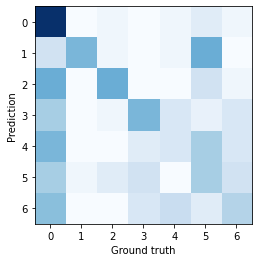

In [83]:
cm = confusion_matrix(y_test_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [84]:
print(top_k_accuracy_score(y_test_, y_pred, k = 2))
print(top_k_accuracy_score(y_test_, y_pred, k = 3))

0.59375
0.7678571428571429


In [85]:
model2.save('/content/gdrive/MyDrive/Digital Signal/Models/Audio - CNN 1D/model2.h5')

## Model 3

In [86]:
num_classes = 7

model3 = Sequential()

model3.add(Conv1D(64, kernel_size = (10), activation = 'relu', input_shape = (282, 1)))

model3.add(Conv1D(128, kernel_size = (10), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model3.add(MaxPooling1D(pool_size = (8)))
model3.add(Dropout(0.5))

model3.add(Conv1D(128, kernel_size = (10), activation = 'relu', kernel_regularizer = l2(0.001), bias_regularizer = l2(0.01)))
model3.add(MaxPooling1D(pool_size = (8)))
model3.add(Dropout(0.5))
model3.add(Flatten())

model3.add(Dense(128, activation = 'relu'))
model3.add(Dropout(0.5))

model3.add(Dense(num_classes, activation = 'softmax'))

In [87]:
model3.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])
history3 = model3.fit(X_train, y_train, batch_size = 32, epochs = 40, verbose = 0)

In [88]:
y_pred = model3.predict(X_test)
y_pred_ = np.argmax(y_pred, axis = 1)
y_test_ = np.argmax(y_test, axis = 1)
print(classification_report(y_test_, y_pred_))

7/7 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.54      0.66      0.59        32
           1       0.61      0.72      0.66        32
           2       0.67      0.69      0.68        32
           3       0.43      0.09      0.15        32
           4       0.31      0.31      0.31        32
           5       0.30      0.25      0.27        32
           6       0.42      0.62      0.50        32

    accuracy                           0.48       224
   macro avg       0.47      0.48      0.45       224
weighted avg       0.47      0.48      0.45       224



Text(0, 0.5, 'Prediction')

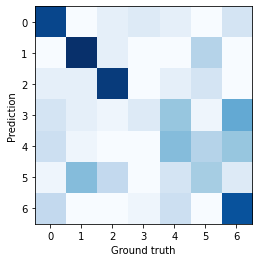

In [89]:
cm = confusion_matrix(y_test_, y_pred_)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

In [90]:
print(top_k_accuracy_score(y_test_, y_pred, k = 2))
print(top_k_accuracy_score(y_test_, y_pred, k = 3))

0.6741071428571429
0.7991071428571429


In [91]:
model3.save('/content/gdrive/MyDrive/Digital Signal/Models/Audio - CNN 1D/model3.h5')